# Compare core-core modules in PAO1 vs PA14

This notebook examines how _stable_ core genes are across strains PAO1, PA14. Here we start with a given PAO1 gene and rank who its related to from most to least correlated. We then ask if the homologous PA14 gene as the same ranking. If they do, then this gene is considered _stable_.

The approach:
1. Make core-core correlation matrix
2. For given core gene A, get rank of how other genes are correlated to A in PAO1. Do the same in PA14.
3. Are the correlations for homologous genes correlated?
4. Each gene will have a correlation score
5. Which genes have the most similar transcriptional relationships (i.e., highest correlation)? Which are the least? What does the distribution of stabilities look like?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import scipy.stats
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from scripts import utils, paths

random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Params
high_threshold = 0.5
low_threshold = 0.2

In [3]:
# Output filenames
pao1_similarity_dist_filename = "pao1_similarity_scores_dist.svg"
pa14_similarity_dist_filename = "pa14_similarity_scores_dist.svg"

# Files containing genes with highest and lowest transcriptional similarity scores high and low
pao1_similarity_scores_filename = "pao1_similarity_scores.tsv"
pa14_similarity_scores_filename = "pa14_similarity_scores.tsv"

In [4]:
# Import correlation matrix
pao1_corr_filename = paths.PAO1_CORR_LOG_SPELL_CORE
pa14_corr_filename = paths.PA14_CORR_LOG_SPELL_CORE

pao1_corr = pd.read_csv(pao1_corr_filename, sep="\t", index_col=0, header=0)
pa14_corr = pd.read_csv(pa14_corr_filename, sep="\t", index_col=0, header=0)

In [5]:
print(pao1_corr.shape)
pao1_corr.head()

(5361, 5361)


,PA4412,PA5383,PA4742,PA0901,PA1841,PA1492,PA3372,PA0568,PA3247,PA2744,...,PA4238,PA0369,PA4135,PA4613,PA2421,PA2158,PA5547,PA0757,PA5276,PA0487
PA4412,1.000000,-0.141173,0.049066,0.325140,-0.005261,0.287467,-0.035581,0.023576,0.186870,0.080776,...,0.037389,0.259796,-0.012420,0.055894,0.035177,0.045921,-0.025459,-0.146546,-0.035633,-0.033798
PA5383,-0.141173,1.000000,-0.074224,-0.045438,0.137329,-0.131583,-0.004467,-0.068039,0.004001,-0.094251,...,-0.062900,-0.211946,0.089213,0.047569,0.017375,0.111890,0.094645,-0.097520,0.150500,0.092036
PA4742,0.049066,-0.074224,1.000000,-0.071469,0.072872,-0.024817,0.062140,0.009830,0.150178,0.398226,...,0.306203,0.104433,0.031172,0.133546,0.112291,0.004815,-0.067803,0.197395,0.096258,-0.032157
PA0901,0.325140,-0.045438,-0.071469,1.000000,0.044982,0.325188,0.027290,-0.242171,0.098943,0.029860,...,-0.015233,0.130314,-0.039794,0.002166,-0.033972,-0.029041,-0.114788,0.054984,0.063575,0.018688
PA1841,-0.005261,0.137329,0.072872,0.044982,1.000000,-0.067455,-0.131038,-0.000246,0.329879,-0.060528,...,-0.082858,-0.224427,0.101370,0.053871,0.077519,0.014556,0.181815,0.063821,-0.022015,-0.057655


In [6]:
print(pa14_corr.shape)
pa14_corr.head()

(5357, 5357)


,PA14_16360,PA14_35370,PA14_36200,PA14_16840,PA14_14450,PA14_61130,PA14_32290,PA14_27440,PA14_60860,PA14_57960,...,PA14_03870,PA14_67200,PA14_26350,PA14_63800,PA14_48870,PA14_53630,PA14_61400,PA14_32190,PA14_15910,PA14_15150
PA14_16360,1.000000,-0.053759,-0.016523,-0.100274,0.041042,-0.037822,0.171754,-0.088034,0.059835,-0.066380,...,-0.198524,0.140701,-0.104774,0.129534,-0.014667,0.036116,0.037170,-0.163292,-0.142163,-0.007243
PA14_35370,-0.053759,1.000000,-0.064671,0.025974,-0.128778,0.008655,0.094154,0.025966,0.036372,0.086751,...,0.005884,-0.106865,0.074859,0.108760,0.013042,0.106923,-0.079950,0.103699,0.018330,-0.042826
PA14_36200,-0.016523,-0.064671,1.000000,0.026716,0.046143,-0.000141,0.113928,0.146701,-0.079708,-0.027166,...,0.093260,-0.092810,-0.065828,0.090592,-0.167372,0.053684,0.119158,-0.106810,-0.022233,-0.038808
PA14_16840,-0.100274,0.025974,0.026716,1.000000,-0.051800,-0.167733,0.082361,0.072369,0.040932,0.010365,...,-0.037459,-0.166393,0.130175,0.151406,-0.027526,-0.127980,0.165293,-0.078156,-0.068760,0.009644
PA14_14450,0.041042,-0.128778,0.046143,-0.051800,1.000000,0.001439,0.069954,0.065652,-0.082042,0.141730,...,-0.030172,-0.033828,0.063999,0.096741,-0.072391,0.032670,0.042519,0.072602,0.273379,0.021431


## Get mapping from PAO1 to PA14

In [7]:
pao1_annotation_filename = paths.GENE_PAO1_ANNOT
pa14_annotation_filename = paths.GENE_PA14_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(pao1_annotation_filename, "pao1")
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(pa14_annotation_filename, "pa14")

In [8]:
pao1_gene_name_map = gene_mapping_pao1["Name"].to_frame()
pa14_gene_name_map = gene_mapping_pa14["Name"].to_frame()

In [9]:
# Function to compare gene ranking
def compare_gene_relationships(gene_mapping_dict, mapping_to, pao1_corr, pa14_corr):
    # Only use genes with 1-1 mapping
    gene_mapping = gene_mapping_dict.query("num_mapped_genes==1")

    # Map PAO1 ids to PA14 ids
    # Note: reindex adds NaN in locations where there is no previous index, so PAO1 genes in the keys of the
    # dictionary that are not found in our correlation matrix were added as NaN columns
    # Instead we're using rename here, which drops any extra values that are not contained in our dictionary
    if mapping_to == "pa14":
        gene_mapping = gene_mapping["PA14_ID"].to_dict()

        shared_genes_dict = set(gene_mapping.keys()).intersection(pao1_corr.index)
        pao1_corr = pao1_corr.loc[shared_genes_dict, shared_genes_dict]

        pao1_corr_mapped = pao1_corr.rename(mapper=gene_mapping, axis=0).rename(
            mapper=gene_mapping, axis=1
        )

        # There are a handful of cases where multiple PAO1 ids map to the same PA14 id
        # results in duplicate PA14 ids, for our purposes we will remove this ambiguity
        pao1_corr_mapped = pao1_corr_mapped.loc[
            ~pao1_corr_mapped.index.duplicated(keep=False),
            ~pao1_corr_mapped.columns.duplicated(keep=False),
        ]
        rows = []
        for pao1_mapped_id in pao1_corr_mapped.index:

            # Check if mapped gene exist in other strain
            if pao1_mapped_id in list(pa14_corr.index):
                pao1_id = list(gene_mapping.keys())[
                    list(gene_mapping.values()).index(pao1_mapped_id)
                ]
                pao1_corr_scores = pao1_corr_mapped[pao1_mapped_id]
                pa14_corr_scores = pa14_corr[pao1_mapped_id]

                # Get shared genes
                shared_genes = list(
                    set(pao1_corr_scores.index).intersection(
                        set(pa14_corr_scores.index)
                    )
                )

                # Index by shared genes
                pao1_corr_scores_reordered = pao1_corr_scores[shared_genes]
                pa14_corr_scores_reordered = pa14_corr_scores[shared_genes]

                # Check that there are no NaNs (i.e. check that index mapping works correctly)
                assert pao1_corr_scores_reordered[
                    pao1_corr_scores_reordered.isna()
                ].empty
                assert pa14_corr_scores_reordered[
                    pa14_corr_scores_reordered.isna()
                ].empty

                # Get correlation score
                # Make dataframe  with PAO1 id, PA14 homolog, correlation score
                corr_coef, pval = scipy.stats.pearsonr(
                    pao1_corr_scores_reordered.values, pa14_corr_scores_reordered.values
                )

                rows.append(
                    {
                        "PAO1 id": pao1_id,
                        "PA14 homolog id": pao1_mapped_id,
                        "Transcriptional similarity across strains": corr_coef,
                        "P-value": pval,
                    }
                )

    elif mapping_to == "pao1":
        gene_mapping = gene_mapping["PAO1_ID"].to_dict()

        shared_genes_dict = set(gene_mapping.keys()).intersection(pa14_corr.index)
        pa14_corr = pa14_corr.loc[shared_genes_dict, shared_genes_dict]

        pa14_corr_mapped = pa14_corr.rename(mapper=gene_mapping, axis=0).rename(
            mapper=gene_mapping, axis=1
        )

        # There are a handful of cases where multiple PAO1 ids map to the same PA14 id
        # results in duplicate PA14 ids, for our purposes we will remove this ambiguity
        pa14_corr_mapped = pa14_corr_mapped.loc[
            ~pa14_corr_mapped.index.duplicated(keep=False),
            ~pa14_corr_mapped.columns.duplicated(keep=False),
        ]

        rows = []
        for pa14_mapped_id in pa14_corr_mapped.index:

            # Check if mapped gene exist in other strain
            if pa14_mapped_id in list(pao1_corr.index):
                pa14_id = list(gene_mapping.keys())[
                    list(gene_mapping.values()).index(pa14_mapped_id)
                ]
                pa14_corr_scores = pa14_corr_mapped[pa14_mapped_id]
                pao1_corr_scores = pao1_corr[pa14_mapped_id]

                # Get shared genes
                shared_genes = list(
                    set(pao1_corr_scores.index).intersection(
                        set(pa14_corr_scores.index)
                    )
                )

                # Index by shared genes
                pao1_corr_scores_reordered = pao1_corr_scores[shared_genes]
                pa14_corr_scores_reordered = pa14_corr_scores[shared_genes]

                # Check that there are no NaNs (i.e. check that index mapping works correctly)
                assert pao1_corr_scores_reordered[
                    pao1_corr_scores_reordered.isna()
                ].empty
                assert pa14_corr_scores_reordered[
                    pa14_corr_scores_reordered.isna()
                ].empty

                # Get correlation score
                # Make dataframe  with PAO1 id, PA14 homolog, correlation score
                corr_coef, pval = scipy.stats.pearsonr(
                    pao1_corr_scores_reordered.values, pa14_corr_scores_reordered.values
                )

                rows.append(
                    {
                        "PA14 id": pa14_id,
                        "PAO1 homolog id": pa14_mapped_id,
                        "Transcriptional similarity across strains": corr_coef,
                        "P-value": pval,
                    }
                )

    corr_summary = pd.DataFrame(rows)
    return corr_summary

In [10]:
pao1_corr_df = compare_gene_relationships(
    gene_mapping_pao1, "pa14", pao1_corr, pa14_corr
)
pa14_corr_df = compare_gene_relationships(
    gene_mapping_pa14, "pao1", pao1_corr, pa14_corr
)

In [11]:
# Add gene name column
pao1_corr_df = pao1_corr_df.set_index("PAO1 id")
pao1_corr_df = pao1_corr_df.merge(
    pao1_gene_name_map, left_index=True, right_index=True, how="left"
)

pa14_corr_df = pa14_corr_df.set_index("PA14 id")
pa14_corr_df = pa14_corr_df.merge(
    pa14_gene_name_map, left_index=True, right_index=True, how="left"
)

In [12]:
print(pao1_corr_df.shape)
pao1_corr_df.head()

(5349, 4)


,PA14 homolog id,Transcriptional similarity across strains,P-value,Name
PAO1 id,,,,
PA1950,PA14_39280,0.353718,1.962739e-157,rbsK
PA4872,PA14_64440,0.381711,4.085891e-185,NaN
PA3680,PA14_16770,0.381384,8.943350e-185,NaN
PA0586,PA14_07650,0.542184,0.000000e+00,NaN
PA1468,PA14_45450,0.365443,1.080005e-168,NaN


In [13]:
print(pa14_corr_df.shape)
pa14_corr_df.head()

(5348, 4)


,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name
PA14 id,,,,
PA14_09290,PA4224,0.417279,2.157278e-224,pchG
PA14_63890,PA4832,0.245412,3.443885e-74,NaN
PA14_53110,PA0863,0.296757,3.538269e-109,NaN
PA14_38990,PA1975,0.268808,3.474350e-89,NaN
PA14_48410,PA1227,0.346066,2.595807e-150,NaN


## Plots

In [14]:
# Add label for most and least stable genes
pao1_corr_df["label"] = ""
pa14_corr_df["label"] = ""
pao1_corr_df.loc[
    pao1_corr_df["Transcriptional similarity across strains"] > high_threshold, "label"
] = "most stable"
pao1_corr_df.loc[
    pao1_corr_df["Transcriptional similarity across strains"] < low_threshold, "label"
] = "least stable"

pa14_corr_df.loc[
    pa14_corr_df["Transcriptional similarity across strains"] > high_threshold, "label"
] = "most stable"
pa14_corr_df.loc[
    pa14_corr_df["Transcriptional similarity across strains"] < low_threshold, "label"
] = "least stable"

Text(0.5, 1.0, 'Similarity of core-core modules PAO1 to PA14')

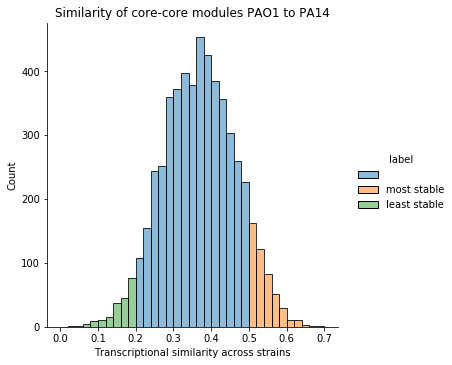

In [15]:
# Plot distribution of correlation scores
# This scores indicate how transcriptionally similar genes are across PAO1 and PA14 strains
fig_pao1 = sns.displot(
    data=pao1_corr_df,
    x="Transcriptional similarity across strains",
    hue="label",
    bins=np.linspace(0, 0.7, 36),
)
# TO DO
# Select certain colors
# Remove empty legend

plt.title("Similarity of core-core modules PAO1 to PA14")

Text(0.5, 1.0, 'Similarity of core-core modules PA14 to PAO1')

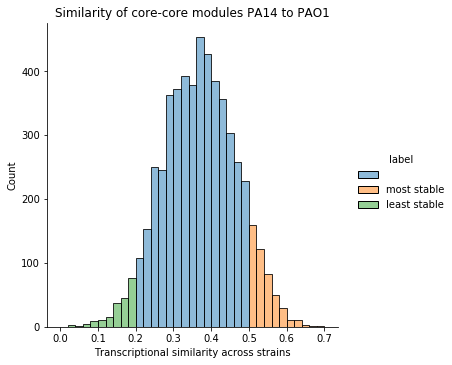

In [16]:
fig_pa14 = sns.displot(
    data=pa14_corr_df,
    x="Transcriptional similarity across strains",
    hue="label",
    bins=np.linspace(0, 0.7, 36),
)
plt.title("Similarity of core-core modules PA14 to PAO1")

In [17]:
# Select genes that are on the high and low end to examine, map gene names
high_pao1 = pao1_corr_df[
    pao1_corr_df["Transcriptional similarity across strains"] > high_threshold
]
low_pao1 = pao1_corr_df[
    pao1_corr_df["Transcriptional similarity across strains"] < low_threshold
]

In [18]:
high_pa14 = pa14_corr_df[
    pa14_corr_df["Transcriptional similarity across strains"] > high_threshold
]
low_pa14 = pa14_corr_df[
    pa14_corr_df["Transcriptional similarity across strains"] < low_threshold
]

In [19]:
high_pao1.head()

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA0586,PA14_07650,0.542184,0.0,NaN,most stable
PA3382,PA14_20330,0.536648,0.0,phnE,most stable
PA3803,PA14_14880,0.527805,0.0,gcpE,most stable
PA3162,PA14_23330,0.526218,0.0,rpsA,most stable
PA5114,PA14_67530,0.598257,0.0,NaN,most stable


In [20]:
high_pa14.head()

,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_65170,PA4934,0.506320,0.0,rpsR,most stable
PA14_08860,PA4262,0.634587,0.0,rplD,most stable
PA14_08830,PA4265,0.580572,0.0,tufA,most stable
PA14_08920,PA4256,0.566028,0.0,rplP,most stable
PA14_12410,PA3975,0.503409,0.0,thiD,most stable


In [21]:
low_pao1.head()

,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA3077,PA14_24350,0.110608,4.956116e-16,cprR,least stable
PA2929,PA14_26160,0.154206,7.995374e-30,NaN,least stable
PA1962,PA14_39150,0.170838,2.577943e-36,azoR2,least stable
PA1183,PA14_49130,0.194419,1.019380e-46,dctA,least stable
PA4973,PA14_65740,0.142356,1.285614e-25,thiC,least stable


In [22]:
low_pa14.head()

,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_48650,PA1210,0.138729,2.148849e-24,NaN,least stable
PA14_17810,PA3593,0.188964,3.546025e-44,NaN,least stable
PA14_58800,PA4531,0.165628,3.351769e-34,NaN,least stable
PA14_55150,PA0708,0.197906,2.277622e-48,NaN,least stable
PA14_53090,PA0864,0.085195,4.369153e-10,NaN,least stable


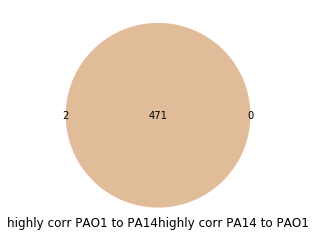

In [23]:
# Check if the highly correlated genes from PAO1 to PA14 are the same as the ones from PA14 to PAO1
high_pao1_set = set(high_pao1["PA14 homolog id"])
high_pa14_set = set(high_pa14.index)
venn2(
    [high_pao1_set, high_pa14_set],
    set_labels=("highly corr PAO1 to PA14", "highly corr PA14 to PAO1"),
)

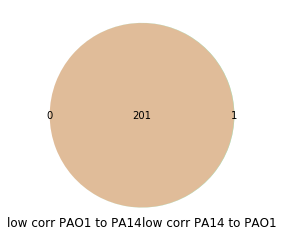

In [24]:
# Check if the lowly correlated genes from PAO1 to PA14 are the same as the ones from PA14 to PAO1
low_pao1_set = set(low_pao1["PA14 homolog id"])
low_pa14_set = set(low_pa14.index)
venn2(
    [low_pao1_set, low_pa14_set],
    set_labels=("low corr PAO1 to PA14", "low corr PA14 to PAO1"),
)

In [25]:
# Missing genes are either not measured in PAO1 or there was not a 1-1 mapping between PAO1 and PA14
# Since there are so few I'm not really worried about these
for missing_pa14 in list(low_pa14_set.difference(low_pao1_set)):
    print(missing_pa14 in pao1_corr_df["PA14 homolog id"])

False


In [26]:
# Save
fig_pao1.savefig(
    pao1_similarity_dist_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

fig_pa14.savefig(
    pa14_similarity_dist_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

In [27]:
# Save transcriptional similarity df
pao1_corr_df.to_csv(pao1_similarity_scores_filename, sep="\t")
pa14_corr_df.to_csv(pa14_similarity_scores_filename, sep="\t")

**Takeaways:**
The distribution plots are the distribution of correlation scores, which represent how correlated a core gene was with its homolog. As an example, say we have core gene PA0001, we can get its correlation profile (i.e. the row of the correlation matrix) that tells us which core genes PA0001 is highly and lowly correlated with. Then we can map PA0001 to its homolog in PA14 and get its correlation profile. Finally we can take the correlation of those correlation profile to determine how consistent PA0001's relationships are across strains. Genes with a high correlation score (right tail of the distribution) represent genes that are stable and are core genes that are related to the same set of core genes in PAO1 and PA14. While genes with a low correlation score (left tail of the distribution) represent genes that are unstable and are core genes that are not related to the same set of core genes in PAO1 and PA14.

* Some of the the highly consistent core genes include those related to type VI secretion system that plays an important role in resistance of biofilms to antibiotics (_tssC1_, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3187457/; _hcp1_, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2831478/; _tssF1_)

* Some of the not consistent core genes include _gloA2_ (related to metabolism); PA3507, PA0478 (putative enzymes); PA4685 (hypothetical protein)